In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [5]:
df = pd.read_csv('cleaned_steam_data.csv', encoding='utf-8')
df.head()

,AppID,Name,Release_date,Peak_CCU,Developers,Publishers,Windows,Mac,Linux,Required_age,Categories,Genres,Achievements,Metacritic_score,Positive_ratings,Negative_ratings,Average_playtime,Median_playtime,Price
0,263380,Driftmoon,2014-01-03,1,"Ville Mönkkönen,Anne Mönkkönen",Instant Kingdom,True,True,True,0,"Single-player,Steam Achievements,Captions avai...","Adventure,Indie,RPG",15,73,223,28,6,6,14.99
1,263340,Continue?9876543210,2014-01-03,0,Jason Oda,Jason Oda,True,True,True,0,"Single-player,Partial Controller Support","Action,Adventure,Indie",0,62,97,78,0,0,9.99
2,262550,Gunman Clive,2014-01-03,0,Hörberg Productions,Hörberg Productions,True,False,False,0,"Single-player,Steam Achievements","Action,Indie",9,0,656,86,42,65,1.99
3,264320,Captain Morgane and the Golden Turtle,2014-01-03,0,WizarBox,Reef Entertainment,True,False,False,0,Single-player,"Adventure,Casual",0,0,102,66,264,336,4.99
4,263680,Unearthed: Trail of Ibn Battuta - Episode 1 - ...,2014-01-03,0,Semaphore,Semaphore,True,True,False,0,"Single-player,Steam Achievements,Full controll...","Action,Adventure",7,0,429,380,95,141,4.99


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23239 entries, 0 to 23238
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AppID             23239 non-null  int64  
 1   Name              23239 non-null  object 
 2   Release_date      23239 non-null  object 
 3   Peak_CCU          23239 non-null  int64  
 4   Developers        23239 non-null  object 
 5   Publishers        23239 non-null  object 
 6   Windows           23239 non-null  bool   
 7   Mac               23239 non-null  bool   
 8   Linux             23239 non-null  bool   
 9   Required_age      23239 non-null  int64  
 10  Categories        23239 non-null  object 
 11  Genres            23239 non-null  object 
 12  Achievements      23239 non-null  int64  
 13  Metacritic_score  23239 non-null  int64  
 14  Positive_ratings  23239 non-null  int64  
 15  Negative_ratings  23239 non-null  int64  
 16  Average_playtime  23239 non-null  int64 

In [13]:
# Release date analysis:
df['Release_date'] = pd.to_datetime(df['Release_date'])

dtype('<M8[ns]')

In [14]:
df['Release_year'] = df['Release_date'].dt.year
df['Release_year']

0        2014
1        2014
2        2014
3        2014
4        2014
         ... 
23234    2024
23235    2024
23236    2024
23237    2024
23238    2024
Name: Release_year, Length: 23239, dtype: int32

/var/folders/1p/f9k50hbd1p5346w0jsp81ry40000gn/T/ipykernel_3236/1663836385.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Release_year', palette='viridis')


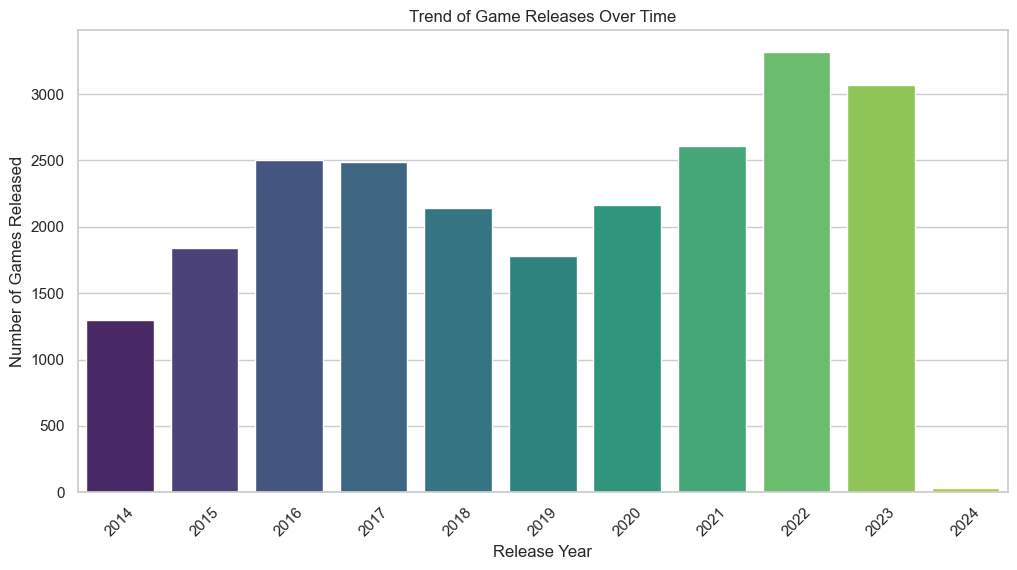

In [15]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the number of game releases per year
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Release_year', palette='viridis')

# Customize the plot
plt.title('Trend of Game Releases Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Games Released')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

In [18]:
# Plotting Peak Concurrent Users Over Time Using groupby
# Group by Release_year and calculate the sum of Peak_CCU
peak_ccu_by_year = df.groupby('Release_year')['Peak_CCU'].sum().reset_index()

# Display the first few rows to check the result
peak_ccu_by_year.head(10)

,Release_year,Peak_CCU
0,2014,116069
1,2015,435538
2,2016,412076
3,2017,686806
4,2018,432253
5,2019,335147
6,2020,691718
7,2021,652874
8,2022,2121411
9,2023,3251780


In [ ]:
peak_ccu_by_year_mean = df.groupby('Release_year')['Peak_CCU'].mean().reset_index()

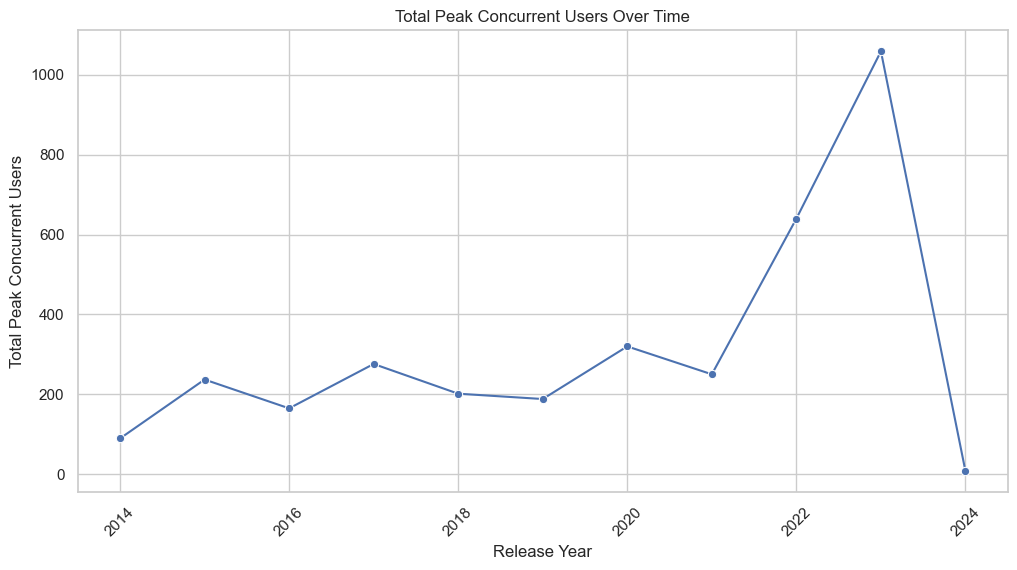

In [24]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the total Peak_CCU by Release Year
plt.figure(figsize=(12, 6))
sns.lineplot(data=peak_ccu_by_year_mean, x='Release_year', y='Peak_CCU', marker='o')

# Customize the plot
plt.title('Total Peak Concurrent Users Over Time')
plt.xlabel('Release Year')
plt.ylabel('Total Peak Concurrent Users')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

In [29]:
len(df['Genres'].unique())
df['Genres'].value_counts()

Genres
Action,Indie                                                   1195
Adventure,Indie                                                1084
Action,Adventure,Indie                                         1075
Casual,Indie                                                    865
Action                                                          723
                                                               ... 
Casual,Free to Play,Strategy,Early Access                         1
Action,Indie,RPG,Simulation,Sports,Early Access                   1
Casual,Free to Play,Indie,Simulation,Strategy,Early Access        1
Adventure,Massively Multiplayer,RPG,Simulation,Early Access       1
Adventure,Casual,Indie,Sports                                     1
Name: count, Length: 1269, dtype: int64

In [33]:
category_grouped = df.groupby(['Release_date', 'Categories'])[['Peak_CCU','Metacritic_score']].sum().reset_index()
category_grouped

,Release_date,Categories,Peak_CCU,Metacritic_score
0,2014-01-03,Single-player,0,0
1,2014-01-03,"Single-player,Partial Controller Support",0,62
2,2014-01-03,"Single-player,Steam Achievements",0,0
3,2014-01-03,"Single-player,Steam Achievements,Captions avai...",1,73
4,2014-01-03,"Single-player,Steam Achievements,Full controll...",0,0
...,...,...,...,...
19319,2024-01-05,"Single-player,Steam Achievements",8,0
19320,2024-01-05,"Single-player,Steam Achievements,Partial Contr...",6,0
19321,2024-01-05,"Single-player,Steam Achievements,Steam Cloud",3,0
19322,2024-01-06,Single-player,3,0


In [36]:
publishers_grouped = df.groupby(['Publishers', 'Release_date'])[['Positive_ratings','Negative_ratings']].sum().reset_index()
publishers_grouped

,Publishers,Release_date,Positive_ratings,Negative_ratings
0,(Myco),2023-12-14,267,5
1,(none),2018-07-25,8503,2642
2,+7 Software,2018-09-18,76,8
3,+Umbrella,2023-04-11,19,1
4,-,2019-07-10,2,2
...,...,...,...,...
22684,Ｌｅｍｏｎ Ｂａｌｍ,2017-01-14,277,13
22685,🚀 Raiser Games,2018-07-19,110,26
22686,🚀 Raiser Games,2019-07-10,3050,470
22687,🚀 Raiser Games,2019-10-31,992,215


In [39]:
top_10 = publishers_grouped.sort_values(by='Positive_ratings', ascending=False).head(10)
top_10

,Publishers,Release_date,Positive_ratings,Negative_ratings
15929,Rockstar Games,2015-04-13,1171197,210154
10111,"KRAFTON, Inc.",2017-12-21,1154655,895978
19669,Ubisoft,2015-12-01,929372,138530
6272,Facepunch Studios,2018-02-08,703687,108223
3229,CD PROJEKT RED,2015-05-18,617738,25020
9417,Innersloth,2018-11-16,577656,51069
2293,Behaviour Interactive Inc.,2016-06-14,494648,112924
15008,Psyonix LLC,2015-07-06,493188,62447
4018,ConcernedApe,2016-02-26,475785,8983
18224,Studio Wildcard,2017-08-27,461567,98701


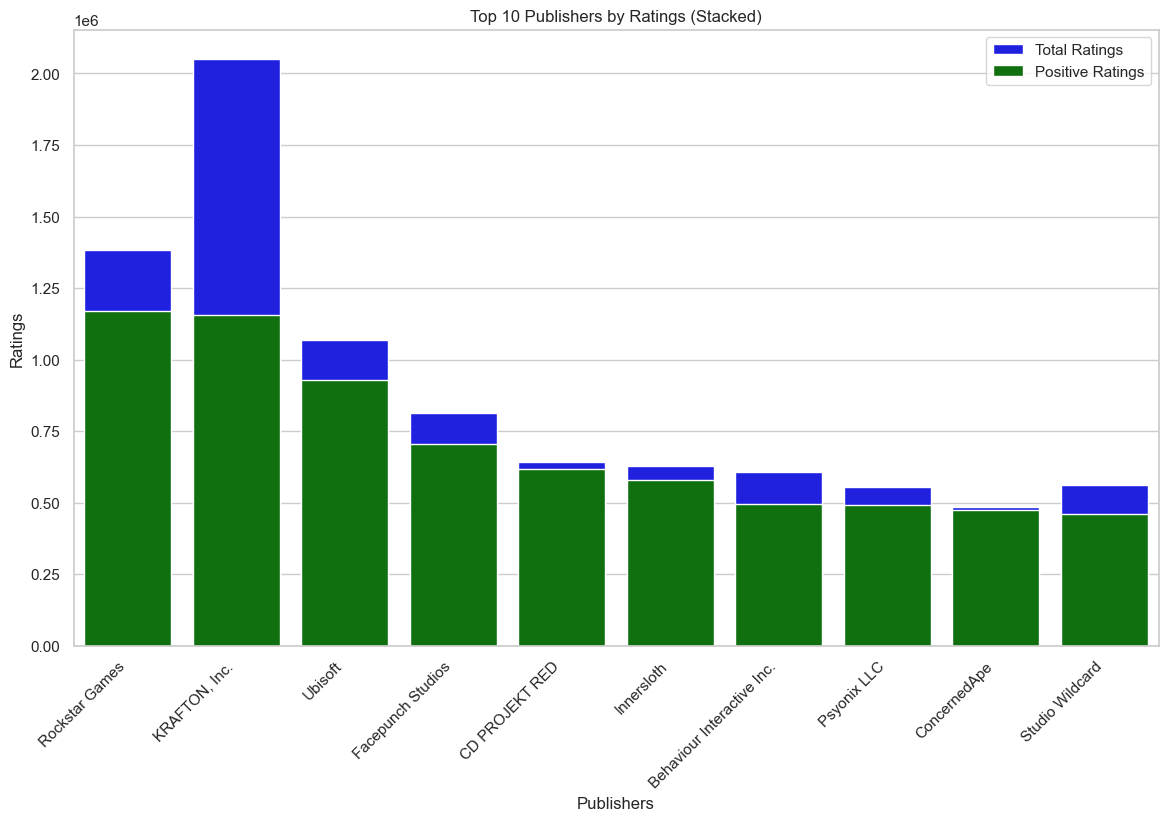

In [40]:
# Calculate the total ratings (positive + negative)
top_10['Total_ratings'] = top_10['Positive_ratings'] + top_10['Negative_ratings']

# Create a stacked bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=top_10, x='Publishers', y='Total_ratings', color='blue', label='Total Ratings')
sns.barplot(data=top_10, x='Publishers', y='Positive_ratings', color='green', label='Positive Ratings')

# Customize the plot
plt.title('Top 10 Publishers by Ratings (Stacked)')
plt.xlabel('Publishers')
plt.ylabel('Ratings')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [41]:
all_3_not_zero = df.loc[(df['Metacritic_score'] != 0) & (df['Positive_ratings'] != 0) & (df['Negative_ratings'] != 0)]
all_3_not_zero

,AppID,Name,Release_date,Peak_CCU,Developers,Publishers,Windows,Mac,Linux,Required_age,Categories,Genres,Achievements,Metacritic_score,Positive_ratings,Negative_ratings,Average_playtime,Median_playtime,Price,Release_year
0,263380,Driftmoon,2014-01-03,1,"Ville Mönkkönen,Anne Mönkkönen",Instant Kingdom,True,True,True,0,"Single-player,Steam Achievements,Captions avai...","Adventure,Indie,RPG",15,73,223,28,6,6,14.99,2014
1,263340,Continue?9876543210,2014-01-03,0,Jason Oda,Jason Oda,True,True,True,0,"Single-player,Partial Controller Support","Action,Adventure,Indie",0,62,97,78,0,0,9.99,2014
6,237950,UFO: Afterlight,2014-01-06,7,Altar Games,Bohemia Interactive,True,False,False,0,"Single-player,Captions available","Indie,Strategy",0,71,285,164,6,11,6.99,2014
11,260650,Cold War,2014-01-08,0,Mindware Studios,THQ Nordic,True,False,False,0,Single-player,Action,0,64,157,79,0,0,4.99,2014
12,235460,METAL GEAR RISING: REVENGEANCE,2014-01-09,1525,PlatinumGames,Konami Digital Entertainment,True,False,False,17,"Single-player,Steam Achievements,Full controll...",Action,60,83,46628,2181,584,399,29.99,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22980,1708010,The Expanse: A Telltale Series,2023-11-20,34,Deck Nine,Telltale,True,False,False,17,"Single-player,Steam Achievements,Partial Contr...","Adventure,RPG",35,76,110,15,0,0,24.99,2023
22992,1647920,Valfaris: Mecha Therion,2023-11-21,6,Steel Mantis,"Big Sugar,East2West Games",True,False,False,0,"Single-player,Steam Achievements,Full controll...","Action,Indie",44,84,82,2,0,0,19.99,2023
22998,1012570,Knuckle Sandwich,2023-11-22,84,Andy Brophy,"Andy Brophy,SUPERHOT PRESENTS",True,False,False,0,"Single-player,Full controller support","Adventure,Indie,RPG",32,74,231,31,173,173,19.99,2023
23026,1469610,Last Train Home,2023-11-28,3792,Ashborne Games,THQ Nordic,True,False,False,0,"Single-player,Steam Achievements,Steam Trading...",Strategy,54,83,230,38,0,0,33.99,2023


/var/folders/1p/f9k50hbd1p5346w0jsp81ry40000gn/T/ipykernel_3236/186307697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_3_not_zero['Net_User_Rating'] = all_3_not_zero['Positive_ratings'] - all_3_not_zero['Negative_ratings']


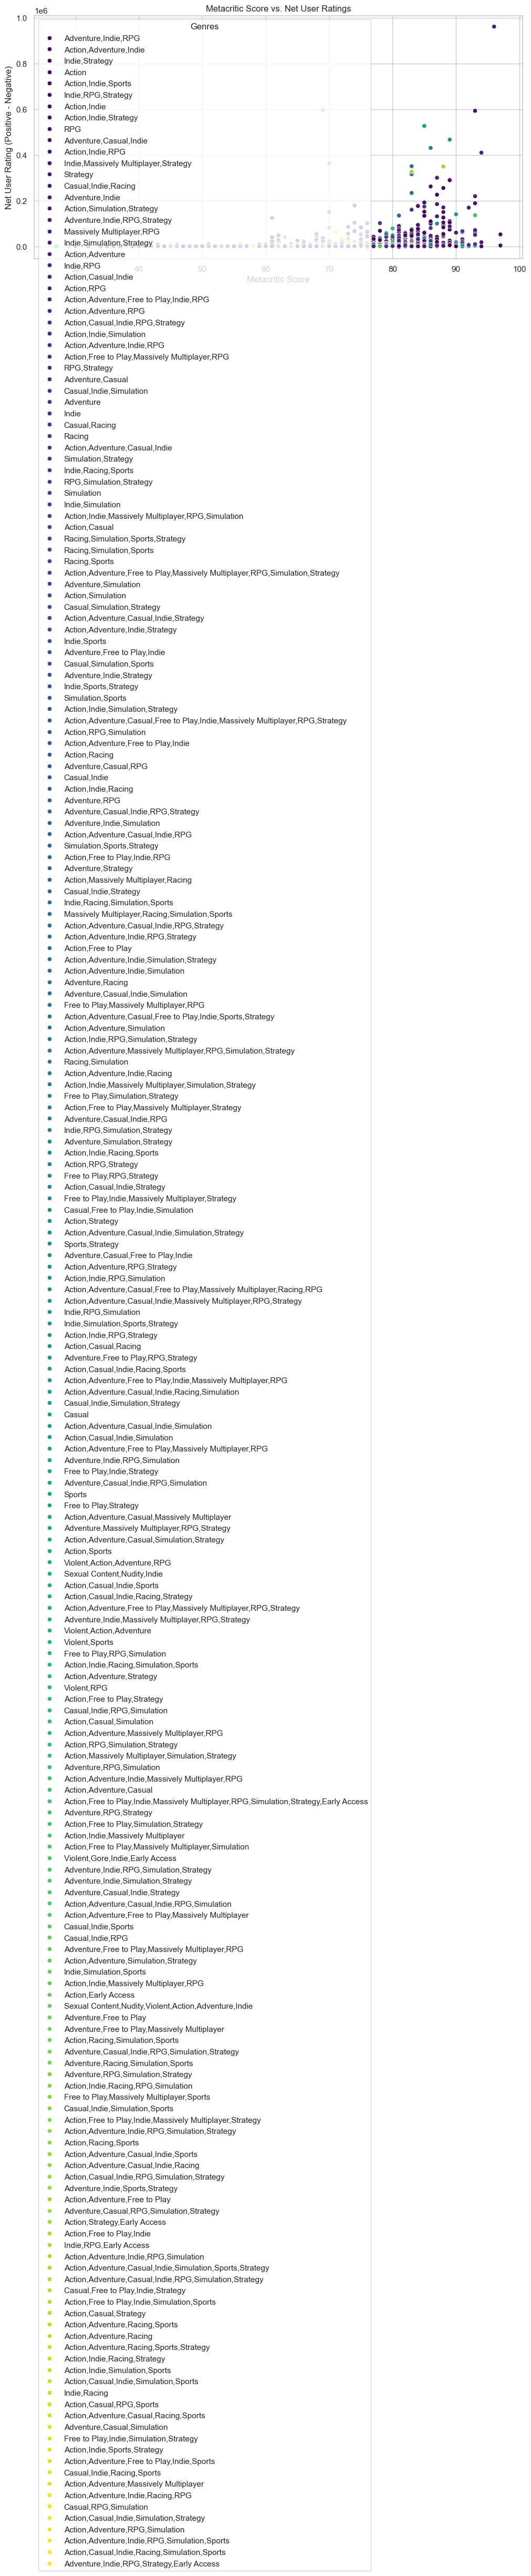

In [42]:
# Calculate the Net User Rating (Positive - Negative)
all_3_not_zero['Net_User_Rating'] = all_3_not_zero['Positive_ratings'] - all_3_not_zero['Negative_ratings']

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=all_3_not_zero, x='Metacritic_score', y='Net_User_Rating', palette='viridis')

# Customize the plot
plt.title('Metacritic Score vs. Net User Ratings')
plt.xlabel('Metacritic Score')
plt.ylabel('Net User Rating (Positive - Negative)')
plt.show()

/var/folders/1p/f9k50hbd1p5346w0jsp81ry40000gn/T/ipykernel_3236/2126431136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_3_not_zero['Metacritic_bin'] = pd.cut(all_3_not_zero['Metacritic_score'], bins=5)
/var/folders/1p/f9k50hbd1p5346w0jsp81ry40000gn/T/ipykernel_3236/2126431136.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_3_not_zero, x='Metacritic_bin', y='Net_User_Rating', palette='viridis')


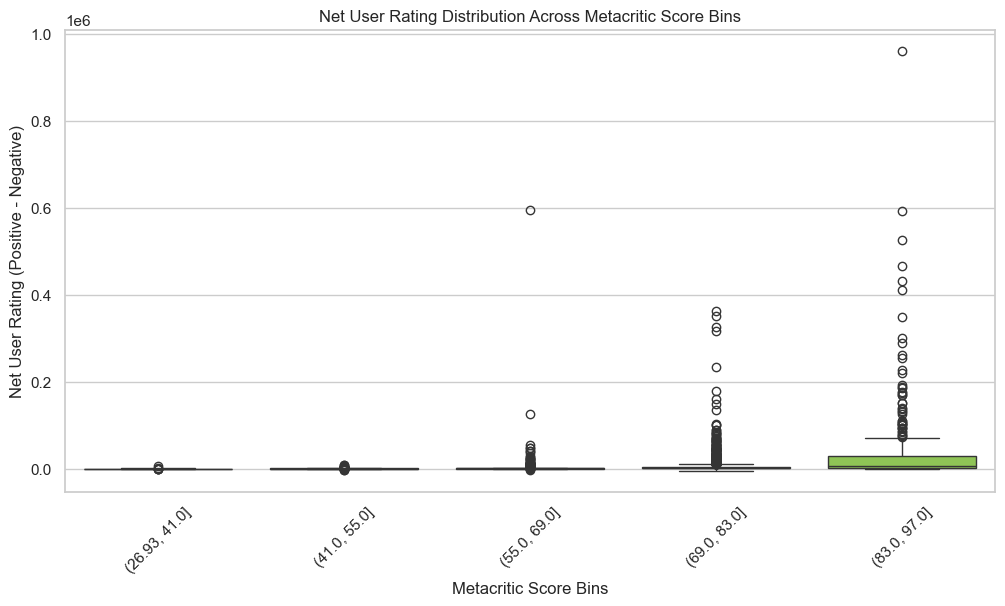

In [44]:
# Create bins for Metacritic Scores
all_3_not_zero['Metacritic_bin'] = pd.cut(all_3_not_zero['Metacritic_score'], bins=5)

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_3_not_zero, x='Metacritic_bin', y='Net_User_Rating', palette='viridis')

# Customize the plot
plt.title('Net User Rating Distribution Across Metacritic Score Bins')
plt.xlabel('Metacritic Score Bins')
plt.ylabel('Net User Rating (Positive - Negative)')
plt.xticks(rotation=45)
plt.show()

In [46]:
# Calculate the frequency of each category across all games
categories_series = df['Categories'].str.split(',').apply(lambda x: pd.Series(x)).stack().str.strip().value_counts()

# Display the frequencies
categories_series

Single-player                 22005
Steam Achievements            14414
Steam Cloud                    9362
Steam Trading Cards            7453
Full controller support        6614
Multi-player                   5879
Partial Controller Support     3476
PvP                            3434
Co-op                          3159
Online PvP                     2775
Steam Leaderboards             2518
Remote Play Together           2293
Shared/Split Screen            2030
Online Co-op                   1986
Remote Play on TV              1406
Stats                          1397
Shared/Split Screen PvP        1319
Shared/Split Screen Co-op      1185
Steam Workshop                 1137
Cross-Platform Multiplayer     1136
In-App Purchases                985
Includes level editor           935
Remote Play on Tablet           677
Captions available              569
MMO                             533
Remote Play on Phone            530
LAN PvP                         233
LAN Co-op                   

In [ ]:
# Convert to a list of strings
df['Categories'] = df['Categories'].apply(lambda x: [s.strip() for s in x.split(',')])

In [53]:
df['Genres'] = df['Genres'].apply(lambda x: [s.strip() for s in x.split(',')])

In [55]:
# Example of accessing one of these lists
print(df['Categories'].iloc[:10])
print(df['Genres'].iloc[:10])

0    [Single-player, Steam Achievements, Captions a...
1          [Single-player, Partial Controller Support]
2                  [Single-player, Steam Achievements]
3                                      [Single-player]
4    [Single-player, Steam Achievements, Full contr...
5                 [Single-player, Steam Trading Cards]
6                  [Single-player, Captions available]
7    [Single-player, Steam Achievements, Steam Trad...
8    [Single-player, Steam Achievements, Steam Work...
9    [Single-player, Steam Achievements, Steam Trad...
Name: Categories, dtype: object
0                              [Adventure, Indie, RPG]
1                           [Action, Adventure, Indie]
2                                      [Action, Indie]
3                                  [Adventure, Casual]
4                                  [Action, Adventure]
5                                      [Casual, Indie]
6                                    [Indie, Strategy]
7                                

In [56]:
df.head()

,AppID,Name,Release_date,Peak_CCU,Developers,Publishers,Windows,Mac,Linux,Required_age,Categories,Genres,Achievements,Metacritic_score,Positive_ratings,Negative_ratings,Average_playtime,Median_playtime,Price,Release_year
0,263380,Driftmoon,2014-01-03,1,"Ville Mönkkönen,Anne Mönkkönen",Instant Kingdom,True,True,True,0,"[Single-player, Steam Achievements, Captions a...","[Adventure, Indie, RPG]",15,73,223,28,6,6,14.99,2014
1,263340,Continue?9876543210,2014-01-03,0,Jason Oda,Jason Oda,True,True,True,0,"[Single-player, Partial Controller Support]","[Action, Adventure, Indie]",0,62,97,78,0,0,9.99,2014
2,262550,Gunman Clive,2014-01-03,0,Hörberg Productions,Hörberg Productions,True,False,False,0,"[Single-player, Steam Achievements]","[Action, Indie]",9,0,656,86,42,65,1.99,2014
3,264320,Captain Morgane and the Golden Turtle,2014-01-03,0,WizarBox,Reef Entertainment,True,False,False,0,[Single-player],"[Adventure, Casual]",0,0,102,66,264,336,4.99,2014
4,263680,Unearthed: Trail of Ibn Battuta - Episode 1 - ...,2014-01-03,0,Semaphore,Semaphore,True,True,False,0,"[Single-player, Steam Achievements, Full contr...","[Action, Adventure]",7,0,429,380,95,141,4.99,2014


In [58]:
df['Release_date'] = df['Release_date'].astype('string')

In [59]:
# Step 2: Convert the DataFrame to a JSON array
json_array = df.to_dict(orient='records')

# Step 3: Save the JSON array to a file
json_file_path = 'output_file.json'  # replace with your desired output file path
with open(json_file_path, 'w') as json_file:
    json.dump(json_array, json_file, indent=4)

print(f"JSON file saved to {json_file_path}")

JSON file saved to output_file.json
